## Import some helpful libraries

In [23]:
print("Version control:\n")
import os     # operating system interfaces
import fnmatch
import random
import datetime
import numpy as np; print("Numpy\t\t", np.__version__)
import matplotlib as mpl; print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib; print("NiBabel\t\t", nib.__version__)
from nibabel.testing import data_path
import math
import pandas as pd; print("Pandas\t\t", pd.__version__)
import sys
import imageio; print("imageio\t\t", imageio.__version__)
import h5py; print("H5py\t\t", h5py.__version__)
import sklearn; print("Scikit-learn\t", sklearn.__version__)
import skimage; print("Scikit-image\t", skimage.__version__)
import tensorflow as tf; print("TensorFlow\t", tf.__version__)
import keras; print("Keras\t\t", keras.__version__)
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv3DTranspose, MaxPooling3D, UpSampling3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard

Version control:

Numpy		 1.18.5
matplotlib	 3.3.2
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.3.1
Keras		 2.3.1


In [22]:
docker build -t gif_your_nifti

SyntaxError: invalid syntax (<ipython-input-22-3b369cd8754d>, line 1)

## Loading Dataset:Validation and Training Dataset (randomly)

In [2]:
## Loading all datasets from path directory

# example_filename = os.path.join(data_path, 'example4d.nii.gz')
print(os.getcwd())     # '/Users/shossein/GitHub/DTI_Clustering'
dirpath = os.chdir("/Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI")
print("\nDirectory is changed into:\n", os.getcwd(), "\n") 
sample_all = []
for sample in fnmatch.filter(os.listdir(dirpath), 'Pat_*_1-post.nii.gz'):
    sample_all.append(sample)
sample_num = len(sample_all)
print("There are", sample_num, "samples.\n")
sample_all.sort()
# print(*sample_all, sep='\t')

/Users/shossein/GitHub/DTI_Clustering

Directory is changed into:
 /Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI 

There are 124 samples.



In [3]:
## Deviding all samples into two groups: Training and Validation datasets randomly

sample_val = random.sample(sample_all, 24)
sample_val.sort()
print(len(sample_val), "Validation samples are:\n")
print(*sample_val, sep='\t')

sample_val_subset = sample_val [0:3]
print("\n\n", len(sample_val_subset), " subset of Validation samples are:\n")
print(*sample_val_subset, sep='\t')

sample_train = [x for x in sample_all if x not in sample_val]
sample_train.sort()
print("\n--------------------------------------------------------------------------------\n", len(sample_train), "Training samples are:\n")
print(*sample_train, sep='\t')

sample_train_subset = sample_train [0:5]
print("\n\n", len(sample_train_subset), " subset of Validation samples are:\n")
print(*sample_train_subset, sep='\t')

24 Validation samples are:

Pat_101_1-post.nii.gz	Pat_113_1-post.nii.gz	Pat_114_1-post.nii.gz	Pat_121_1-post.nii.gz	Pat_131_1-post.nii.gz	Pat_139_1-post.nii.gz	Pat_142_1-post.nii.gz	Pat_17_1-post.nii.gz	Pat_24_1-post.nii.gz	Pat_26_1-post.nii.gz	Pat_2_1-post.nii.gz	Pat_31_1-post.nii.gz	Pat_32_1-post.nii.gz	Pat_36_1-post.nii.gz	Pat_37_1-post.nii.gz	Pat_39_1-post.nii.gz	Pat_44_1-post.nii.gz	Pat_45_1-post.nii.gz	Pat_4_1-post.nii.gz	Pat_62_1-post.nii.gz	Pat_68_1-post.nii.gz	Pat_71_1-post.nii.gz	Pat_95_1-post.nii.gz	Pat_96_1-post.nii.gz


 3  subset of Validation samples are:

Pat_101_1-post.nii.gz	Pat_113_1-post.nii.gz	Pat_114_1-post.nii.gz

--------------------------------------------------------------------------------
 100 Training samples are:

Pat_100_1-post.nii.gz	Pat_102_1-post.nii.gz	Pat_103_1-post.nii.gz	Pat_107_1-post.nii.gz	Pat_108_1-post.nii.gz	Pat_109_1-post.nii.gz	Pat_10_1-post.nii.gz	Pat_110_1-post.nii.gz	Pat_115_1-post.nii.gz	Pat_116_1-post.nii.gz	Pat_117_1-post.nii.gz	Pat_1

## Combine datasets together

In [4]:
## Combine all Training dateset together

data_combined = np.zeros((1, 182, 218, 182, 1))

sample_train = sample_train_subset            # To test in CPU based computer

for sample in sample_train_subset:
#     print(sample)
    img = nib.load(sample)
    img_np = np.asanyarray(img.dataobj)         # Convert data into Numpy array format
    data_64 = np.float64(img_np)                # Convert numpayed data back into the original float64
    data_reshape = np.reshape(data_64, (1, 182, 218, 182, 1))
    data_combined = np.concatenate((data_combined, data_reshape), axis=0)
data_combined = np.delete(data_combined, 0, axis=0)
print("Shape of training dataset:", data_combined.shape)
train_data = data_combined

Shape of training dataset: (5, 182, 218, 182, 1)


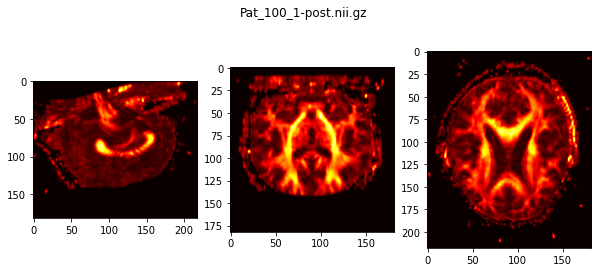

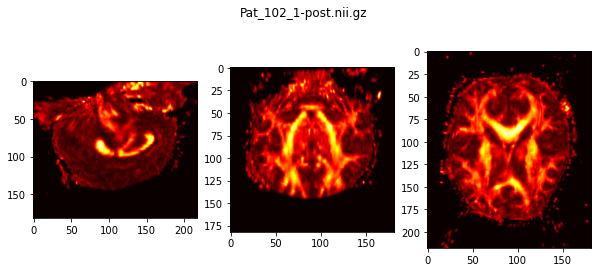

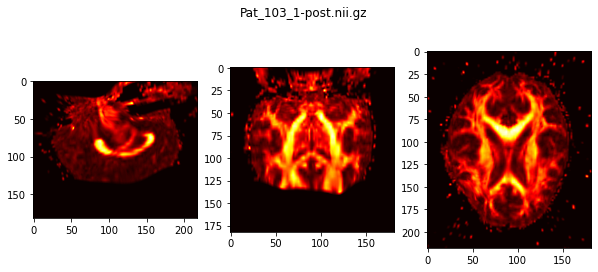

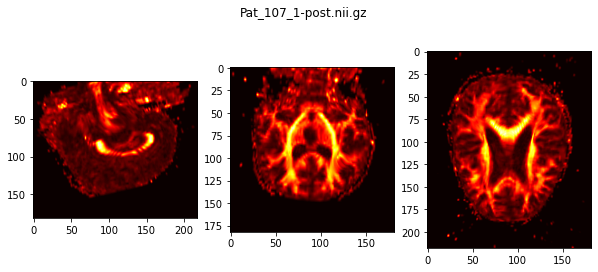

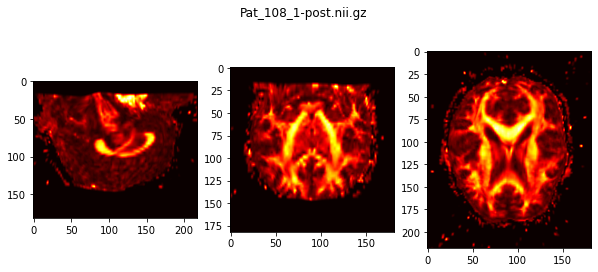

In [5]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray
for m in range(data_combined.shape[0]):
    slice_0 = data_combined[m, 91, :, :, 0]
    slice_1 = data_combined[m, :, 109, :, 0]
    slice_2 = data_combined[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train[m], x=0.5, y=0.9)

In [6]:
## Rescale Training dataset into [0:1]

sample_spec = 2      # A specific sample to show the min and max of that 
print("Range of a sample of original training data:\tMin=", np.min(train_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(train_data[sample_spec, :, :, :, 0]), "\n")
for m in range(train_data.shape[0]):
    for x in range(train_data.shape[1]):
        for y in range(train_data.shape[2]):
            for z in range(train_data.shape[3]):
                if train_data[m,x,y,z] <= 0: train_data[m,x,y,z] = 0
                if train_data[m,x,y,z] > 1: train_data[m,x,y,z] = 1
print("Range of a sample of original data:\t\tMin=", np.min(train_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(train_data[sample_spec, :, :, :, 0]), "\n")

Range of a sample of original training data:	Min= -0.0010085757821798325 ,   Max= 0.976529061794281 

Range of a sample of original data:		Min= 0.0 ,   Max= 0.976529061794281 



In [7]:
## Combine all Validation dateset together

data_combined = np.zeros((1, 182, 218, 182, 1))

sample_val = sample_val_subset            # To test in CPU based computer

for sample in sample_val:
#     print(sample)
    img = nib.load(sample)
    img_np = np.asanyarray(img.dataobj)         # Convert data into Numpy array format
    data_64 = np.float64(img_np)                # Convert numpayed data back into the original float64
    data_reshape = np.reshape(data_64, (1, 182, 218, 182, 1))
    data_combined = np.concatenate((data_combined, data_reshape), axis=0)
data_combined = np.delete(data_combined, 0, axis=0)
print("Shape of validation dataset:", data_combined.shape)
valid_data = data_combined

Shape of validation dataset: (3, 182, 218, 182, 1)


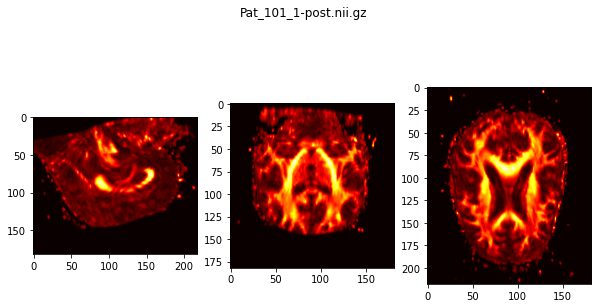

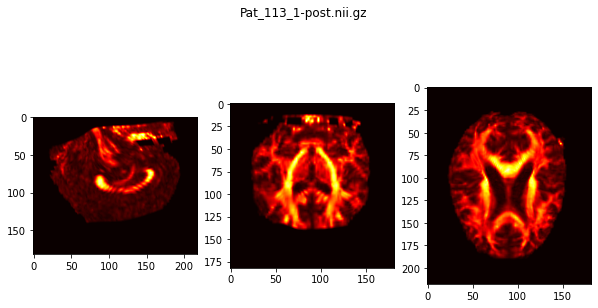

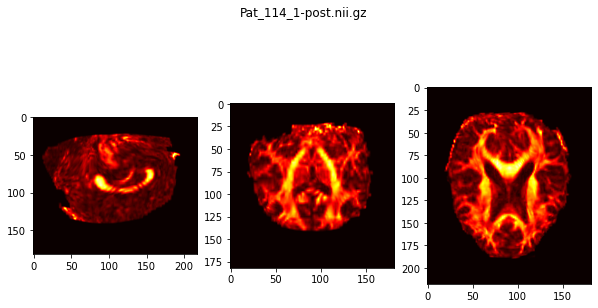

In [8]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

for m in range(data_combined.shape[0]):
    slice_0 = data_combined[m, 91, :, :, 0]
    slice_1 = data_combined[m, :, 109, :, 0]
    slice_2 = data_combined[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val[m], x=0.5, y=1)

In [9]:
## Rescale Validation dataset into [0:1]

sample_spec = 2      # A specific sample to show the min and max of that 

print("Range of a sample of original validation data:\tMin=", np.min(valid_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(valid_data[sample_spec, :, :, :, 0]), "\n")
for m in range(valid_data.shape[0]):
    for x in range(valid_data.shape[1]):
        for y in range(valid_data.shape[2]):
            for z in range(valid_data.shape[3]):
                if valid_data[m,x,y,z] <= 0: valid_data[m,x,y,z] = 0
                if valid_data[m,x,y,z] > 1: valid_data[m,x,y,z] = 1
print("Range of a sample of original data:\t\tMin=", np.min(valid_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(valid_data[sample_spec, :, :, :, 0]), "\n")

Range of a sample of original validation data:	Min= 0.0 ,   Max= 0.9975343942642212 

Range of a sample of original data:		Min= 0.0 ,   Max= 0.9975343942642212 



## Model Design

In [10]:
## Define parameters:

IMAGE_HEIGHT = data_combined.shape[1]
IMAGE_WIDTH = data_combined.shape[2]
IMAGE_DEPTH = data_combined.shape[3]
batch_size = 32
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("input-layer shape:", input_shape)

## Encoder
input_img = Input(shape=(182, 218, 182, 1))
x = Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', name='Conv1')(input_img)
x = MaxPooling3D(pool_size=(13, 13, 13), padding='same')(x)
x = Conv3D(filters=8, kernel_size=(3, 3, 3), padding='same', activation='relu', name='Conv2')(x)
encoded = MaxPooling3D(pool_size=(7, 7, 7), padding='same')(x)
## at this point the representation is (2, 3, 2, 8) i.e. 96-dimensional instead of 7,221,032

## Decoder
x = Conv3DTranspose(filters=4, kernel_size=(3, 3, 3), padding='same', activation='relu', name='DeConv3')(encoded)
x = UpSampling3D(size=(7, 6, 7))(x)
x = Conv3DTranspose(filters=8, kernel_size=(3, 3, 3), padding='same', activation='relu', name='DeConv4')(x)
x = UpSampling3D(size=(13, 12, 13))(x)
decoded = Conv3DTranspose(filters=1, kernel_size=(1, 3, 1), padding='valid', activation='sigmoid', name='DeConv5')(x)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
autoencoder.summary()

input-layer shape: [32, 182, 218, 182, 1]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 182, 218, 182, 16) 448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 17, 14, 16)    0         
_________________________________________________________________
Conv2 (Conv3D)               (None, 14, 17, 14, 8)     3464      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 3, 2, 8)        0         
_________________________________________________________________
DeConv3 (Conv3DTranspose)    (None, 2, 3, 2, 4)        868       
_________________________________________________________________
up_sampling3

## Model Training

In [11]:
print(os.getcwd())
dirpath = os.chdir("/Users/shossein/GitHub/DTI_Clustering")
print("\nDirectory is changed into:\n", os.getcwd(), "\n")

/Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI

Directory is changed into:
 /Users/shossein/GitHub/DTI_Clustering 



In [13]:
## Tensorboard

%load_ext tensorboard
# %reload_ext tensorboard
logdir = os.path.join("CAE_logs", datetime.datetime.now().strftime("%Y_%m_%d____%H_%M_%S"))
tb_callback = TensorBoard(logdir, histogram_freq=1)

## Midel Fit
autoencoder.fit(train_data, train_data, epochs=3, batch_size=batch_size, shuffle=True, validation_data=(valid_data, valid_data), callbacks=[tb_callback], verbose=1)
autoencoder.save_weights("CAE_weights.hdf5")
# autoencoder.load_weights("CAE_weights.hdf5")     # loading weights

Epoch 1/3
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.3764 - val_loss: 0.0000e+00 - val_accuracy: 0.3923
Epoch 2/3
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.3764 - val_loss: 0.0000e+00 - val_accuracy: 0.3923
Epoch 3/3
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.3764 - val_loss: 0.0000e+00 - val_accuracy: 0.3923


In [14]:
tensorboard --logdir=CAE_logs

Reusing TensorBoard on port 6008 (pid 11747), started 0:11:36 ago. (Use '!kill 11747' to kill it.)

In [15]:
tensorboard --logdir=CAE_logs

Reusing TensorBoard on port 6008 (pid 11747), started 0:11:41 ago. (Use '!kill 11747' to kill it.)